# 1. Import Packages

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import xgboost as xgb
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier 
import shap
shap.initjs()

# 2. Loading Data

In [6]:
#load data from EDA 
df= pd.read_csv('/Users/annaparton/Desktop/Springboard/Capstone Project2/Data/project2_df.csv')

# 3. Preprocessing 

In [7]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Station', 'Date', 'Tmax', 'Tmin', 'Tavg',
       'DewPoint', 'WetBulb', 'Sunrise', 'Sunset', 'CodeSum', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'year_train', 'month_train', 'day_train', 'Address', 'Species', 'Trap',
       'Latitude', 'Longitude', 'NumMosquitos', 'WnvPresent', 'day_weather',
       'month_weather', 'year_weather', 'week', 'Species_virus',
       'tavg_celsius', 'wetbulb_celsius', 'relative_humidity', '7day_tavg_c',
       '14day_tavg_c', '21day_tavg_c', '7day_Precip', '14day_Precip',
       '21day_Precip', '7day_rel_humidity', '14day_rel_humidity',
       '21day_rel_humidity', 'daylight_time', 'night_time', 'Precip_binary'],
      dtype='object')

In [8]:
#dropping year, month, day from the train dataset
#dropping address, CodeSum, Trap
#drop date object column, Species with the different types  
df1= df.drop(['Unnamed: 0.1', 'Unnamed: 0', 'CodeSum', 'Address', 'Trap', 'year_train', 'month_train', 'day_train', 'Date', 'Species'], axis=1)

In [9]:
df1.shape

(10506, 38)

## 3a Create X and y

0    9955
1     551
Name: WnvPresent, dtype: int64


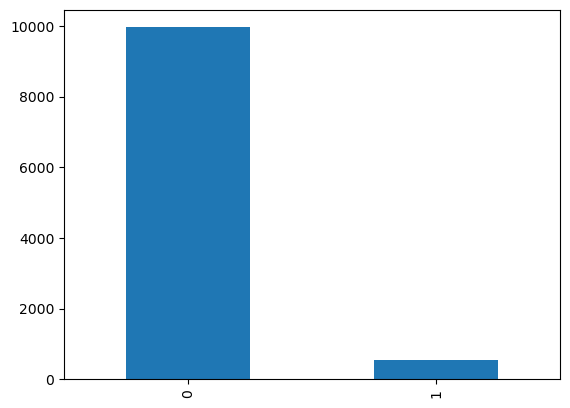

In [11]:
#create X, y to be used in the train-test-split arguments
X= df1.drop('WnvPresent', axis=1)
y= df1['WnvPresent']

y.value_counts().plot(kind='bar')
print(y.value_counts())

## 3b Resampling

Resampling from the minority group (WnvPresent =1)

In [12]:
#oversampling from the minority group
ros = RandomOverSampler(sampling_strategy=.1, random_state= 42)
X_over, y_over = ros.fit_resample(X, y)

0    9955
1     995
Name: WnvPresent, dtype: int64


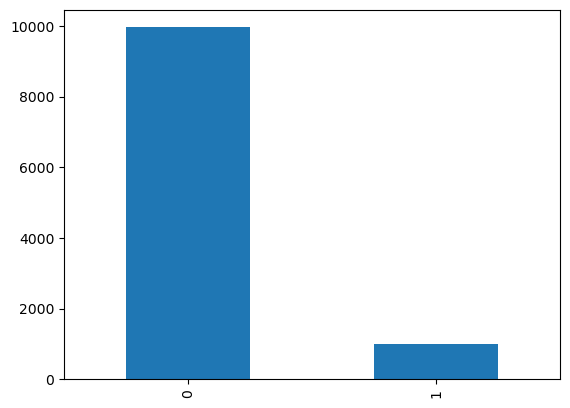

In [14]:
#graphing y value counts to make sure even amount of WnvPresent and not
y_over.value_counts().plot(kind='bar')
print(y_over.value_counts())

In [15]:
#undersample the zeros in data
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_over, y_over)

0    995
1    995
Name: WnvPresent, dtype: int64


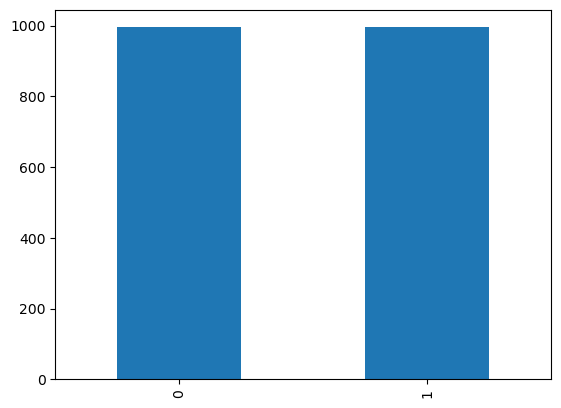

In [16]:
#graphing y value counts to make sure even amount of WnvPresent and not
y_resampled.value_counts().plot(kind='bar')
print(y_resampled.value_counts())

## 3c Train-test-split

In [150]:
#keeping columns based upon heatmap on EDA notebook 
#not keeping all duplicate columns (e.g. 14 or 21 columns of tavg, relative humidity, precipitation)

X_resampled= X_resampled[['DewPoint', 'StnPressure', 'SeaLevel', 'ResultSpeed',
                   'AvgSpeed', 'Latitude', 'Longitude', 'NumMosquitos', 'month_weather', 
                   'year_weather', 'week', 'Species_virus',
       'tavg_celsius', 'wetbulb_celsius', 'relative_humidity', '7day_tavg_c',
        '7day_Precip', '7day_rel_humidity',
     'daylight_time', 'night_time']]

In [151]:
#split the data to prepare it for modeling
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=47)

In [152]:
X_train.head()

,DewPoint,StnPressure,SeaLevel,ResultSpeed,AvgSpeed,Latitude,Longitude,NumMosquitos,month_weather,year_weather,week,Species_virus,tavg_celsius,wetbulb_celsius,relative_humidity,7day_tavg_c,7day_Precip,7day_rel_humidity,daylight_time,night_time
7606,70,29.26,29.89,5.8,6.3,41.878114,-87.629798,1,9,2011,35,1,28.888889,23.888889,63.672681,28.888889,0.000,63.672681,1310,1090
4228,68,29.03,29.68,6.3,10.5,41.723195,-87.649970,13,6,2009,25,1,25.000000,21.111111,69.010264,25.000000,0.870,69.010264,1514,886
2172,54,29.46,30.08,6.1,7.4,41.680946,-87.535198,32,8,2007,33,1,22.777778,16.666667,51.631046,22.777778,0.000,51.631046,1350,1050
7116,68,29.21,29.93,4.0,5.5,41.974689,-87.890615,10,8,2011,31,1,24.444444,21.666667,77.047803,24.444444,0.005,77.047803,1458,942
1282,63,29.34,29.98,2.1,3.7,41.704572,-87.565666,36,8,2007,31,1,26.666667,21.111111,58.651364,26.666667,0.000,58.651364,1466,934


In [153]:
X_train.columns

Index(['DewPoint', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'AvgSpeed',
       'Latitude', 'Longitude', 'NumMosquitos', 'month_weather',
       'year_weather', 'week', 'Species_virus', 'tavg_celsius',
       'wetbulb_celsius', 'relative_humidity', '7day_tavg_c', '7day_Precip',
       '7day_rel_humidity', 'daylight_time', 'night_time'],
      dtype='object')

# 4. Modeling

## 4a Metric Fuctions

In [154]:
#creating classification metric measures
def display_confusion_matrix(ytest, ypred, model) :
    cm = confusion_matrix(ytest, ypred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels =[1,0])
    disp.plot()
    plt.show()
def class_report(ytest, ypred) :
    print(classification_report(ytest, ypred))
    
def feature_importance(model) :
    xgb.plot_importance(model)
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.show()

## 4b Model - Logistic Regression

In [155]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

#have to scale data so data converges 
pipe = make_pipeline(MinMaxScaler(), LogisticRegression())
pipe.fit(X_train.values, y_train.values)
# LogisticRegression
#model_lr = LogisticRegression(random_state=0)
#model_lr.fit(X_train, y_train.values)
 
# Prediction
y_pred = pipe.predict(X_test.values)

In [156]:
# using metrics module for accuracy calculation 
print("Model Logistic Regression ROC AUC score {0:0.4f} : ", roc_auc_score(y_test, y_pred)) 

Model Logistic Regression ROC AUC score {0:0.4f} :  0.7534695710756792


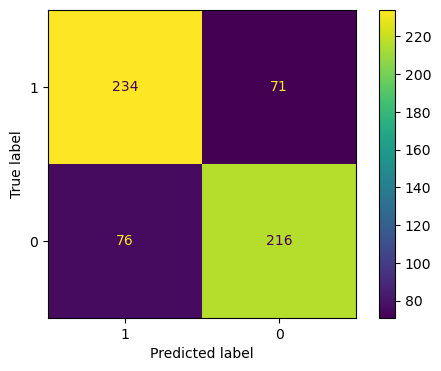

In [157]:
#display confustion matrix for base model of logistic regression
display_confusion_matrix(y_test, y_pred, model_lr)

## 4c Model - Random Forest 

In [158]:
model_rf = RandomForestClassifier(n_estimators = 100, random_state=0)   
  
# Train the model
model_rf.fit(X_train, y_train) 
  
# Make y predictions on the X_test data
y_pred = model_rf.predict(X_test) 
  
# using metrics module for accuracy calculation 
print("Model Random Forest ROC AUC score {0:0.4f} : ", roc_auc_score(y_test, y_pred)) 

Model Random Forest ROC AUC score {0:0.4f} :  0.8263698630136986


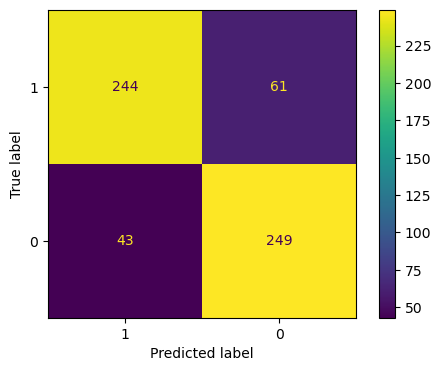

In [159]:
#display confustion matrix for base model of XGBoost
display_confusion_matrix(y_test, y_pred, model_rf)

## 4d Model - Random Forest using Grid Search

In [160]:
#use Grid search on Random Forest model
param_grid = { 
    'n_estimators': [50, 100, 150, 200], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [4, 8, 12], 
    'max_leaf_nodes': [4, 8, 12], 
} 

In [161]:
#train model on different parameters using grid search to find a better model
model_gr_rf = GridSearchCV(RandomForestClassifier(), 
                           param_grid=param_grid) 
model_gr_rf.fit(X_train, y_train) 
print(model_gr_rf.best_estimator_)

RandomForestClassifier(max_depth=4, max_leaf_nodes=12)


In [163]:
#use best parameters from GridSearch above
model_gr_rf_best = RandomForestClassifier(max_depth=8,
                                    max_features=None, 
                                    max_leaf_nodes=12, 
                                    n_estimators=200, random_state = 0) 
model_gr_rf_best.fit(X_train, y_train) 

RandomForestClassifier(max_depth=8, max_features=None, max_leaf_nodes=12,
                       n_estimators=200, random_state=0)

Model Grid Search with Random Forest ROC AUC score: 0.8132


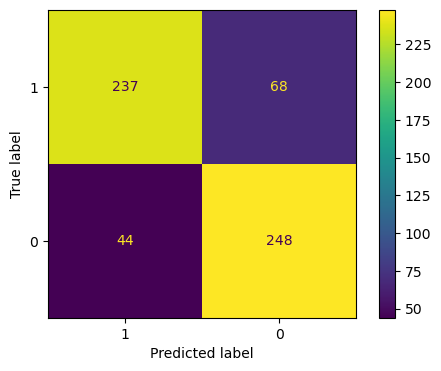

              precision    recall  f1-score   support

           0       0.84      0.78      0.81       305
           1       0.78      0.85      0.82       292

    accuracy                           0.81       597
   macro avg       0.81      0.81      0.81       597
weighted avg       0.81      0.81      0.81       597



In [164]:
#predict y values from X_test set
y_pred = model_gr_rf_best.predict(X_test)

#determine accuracy of model using actual y_test values and predicted y_pred values
print('Model Grid Search with Random Forest ROC AUC score: {0:0.4f}'. format(roc_auc_score(y_test, y_pred)))

#display confustion matrix for base model of XGBoost
display_confusion_matrix(y_test, y_pred, model_gr_rf_best)

#classification report
class_report(y_test, y_pred)

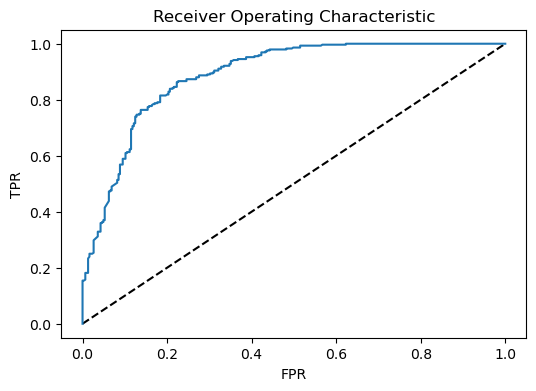

In [165]:
#ROC curve for Random Forest
y_pred_prob1 = model_gr_rf_best.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Random Forest")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

## 4e Model - XGBoost

In [166]:
#setting the base model for XGBoost  
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train, y_train)

#use model to predict y values on X_test set
y_pred = model_xgb.predict(X_test)

XGBoost ROC AUC score: 0.8417


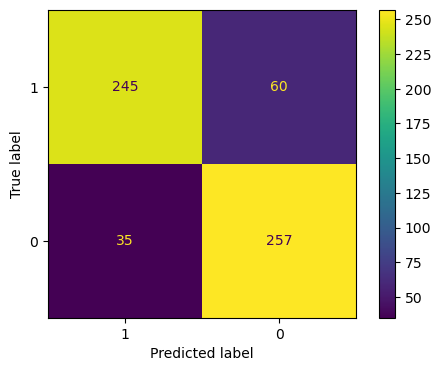

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       305
           1       0.81      0.88      0.84       292

    accuracy                           0.84       597
   macro avg       0.84      0.84      0.84       597
weighted avg       0.84      0.84      0.84       597



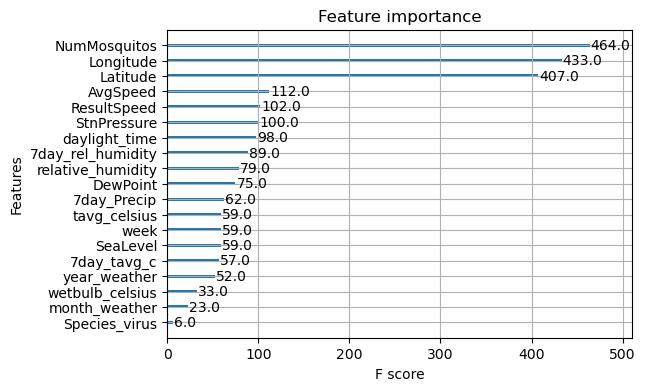

In [167]:
#determine accuracy of model using actual y_test values and predicted y_pred values
print('XGBoost ROC AUC score: {0:0.4f}'. format(roc_auc_score(y_test, y_pred)))

#display confustion matrix for base model of XGBoost
display_confusion_matrix(y_test, y_pred, model_xgb)

#classification report
class_report(y_test, y_pred)

#feature importance
feature_importance(model_xgb)

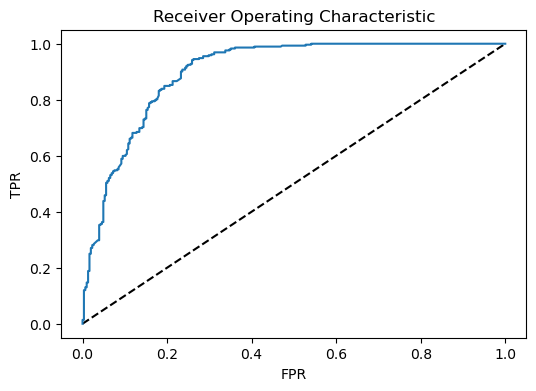

In [209]:
#graph ROC curve
y_pred_prob1 = model_xgb.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Model XGBoost")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.savefig('roc_auc.png')
#plt.show()

## 4f Model - XGBoost using Grid Search

In [169]:
#set estimator
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

In [171]:
#set parameters 
parameters = {
    'max_depth': range (6, 10, 2),
    'n_estimators': range(120, 180, 40),
    'learning_rate': [0.1, 0.2, .3],  
    'min_child_weight' : range(2, 5, 1),
    'colsample_bytree': [0.4, 0.6], 
    'eta': [.1, .2], 
    'gamma': [0.5, 1.5, 3]
}


In [172]:
#grid search with the different parameters listed above 5 cross validations
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    #how many cpus using- set to -1 to use them all
    n_jobs = -1,
    cv = 5
)

In [173]:
#fit the grid search on the X_train and y_train data of the Undersampling data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.4, 0.6], 'eta': [0.1, 0.2],
                         'gamma': [0.5, 1.5, 3],
                         'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': range(6, 10, 2),
                         'min_child_weight': range(2, 5),
                         'n_estimators': range(120, 180, 40)},
             scoring='roc_auc')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=3, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, n_estimators=120, n_jobs=None,
              nthread=4, num_parallel_tree=None, ...)
XGboost with Grid Search ROC AUC score: 0.8302


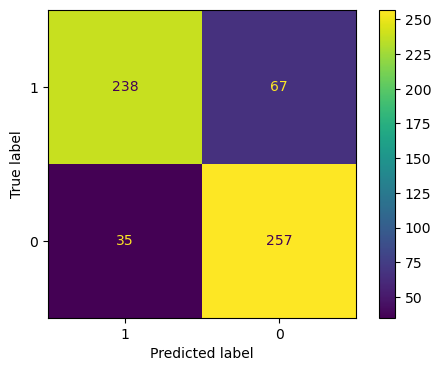

              precision    recall  f1-score   support

           0       0.87      0.78      0.82       305
           1       0.79      0.88      0.83       292

    accuracy                           0.83       597
   macro avg       0.83      0.83      0.83       597
weighted avg       0.83      0.83      0.83       597



In [174]:
#predict y values from X_test set
y_pred = grid_search.predict(X_test)

#print the best parameters from the grid search
print(grid_search.best_estimator_)

#determine accuracy of model using actual y_test values and predicted y_pred values
print('XGboost with Grid Search ROC AUC score: {0:0.4f}'. format(roc_auc_score(y_test, y_pred)))

#display confustion matrix for base model of XGBoost
display_confusion_matrix(y_test, y_pred, grid_search)

#classification report
class_report(y_test, y_pred)

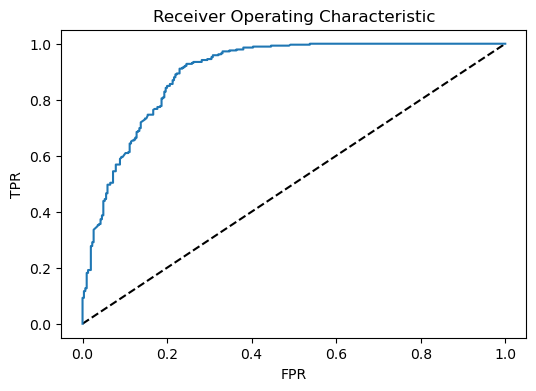

In [193]:
#ROC curve for XGBoost with grid search for OVERsampling data
y_pred_prob1 = grid_search.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Model XGBoost with Grid Search")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
#plt.show()
plt.savefig('ROC_curve.jpeg')

In [204]:
model_xgb_2 = xgb.XGBClassifier(max_depth=6, learning_rate=0.3, colsample_bytree=1, gamma=0, 
                              min_child_weight=1, n_estimators=100)
model_xgb_2.fit(X_train, y_train)

#use model to predict y values on X_test set
y_pred = model_xgb_2.predict(X_test)

XGBoost with default parameters: 0.8417


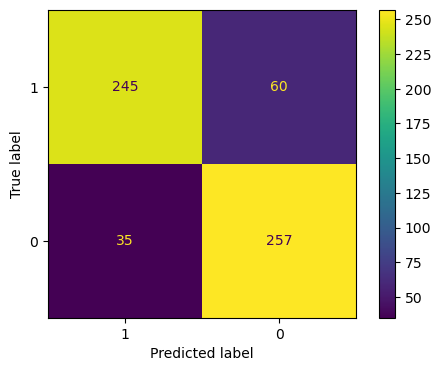

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       305
           1       0.81      0.88      0.84       292

    accuracy                           0.84       597
   macro avg       0.84      0.84      0.84       597
weighted avg       0.84      0.84      0.84       597



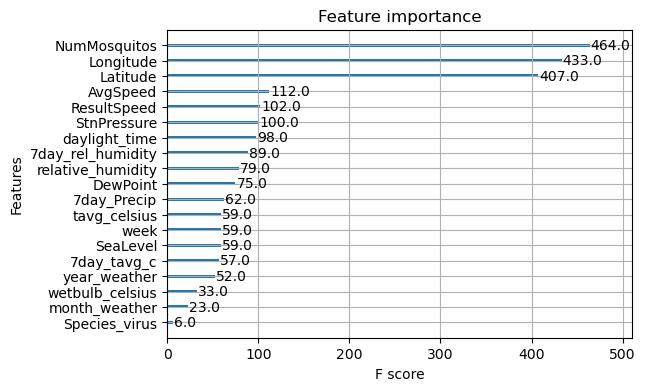

In [205]:
#determine accuracy of model using actual y_test values and predicted y_pred values
print('XGBoost with default parameters: {0:0.4f}'. format(roc_auc_score(y_test, y_pred)))

#display confustion matrix for base model of XGBoost
display_confusion_matrix(y_test, y_pred, model_xgb_2)

#classification report
class_report(y_test, y_pred)

#feature importance
feature_importance(model_xgb_2)

## 4g Model - XGBoost using Hyperopt 

In [211]:
#create the objective function
def objective(space):
    classifier = xgb.XGBClassifier(n_estimators = space['n_estimators'],
                            max_depth = int(space['max_depth']),
                            learning_rate = float(space['learning_rate']),
                            gamma = space['gamma'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree = space['colsample_bytree']
                            )
    
    classifier.fit(X_train, y_train)

    # Applying k-Fold Cross Validation
    from sklearn.model_selection import cross_val_score
    accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
    CrossValMean = accuracies.mean()

    print("CrossValMean:", CrossValMean)

    return{'loss':1-CrossValMean, 'status': STATUS_OK }
#define the space 
space = {
    'max_depth': hp.choice('max_depth', range(3, 11)),
    'learning_rate' : hp.uniform('learning_rate', 0.01, 0.30),
    'n_estimators' : hp.choice('n_estimators', range(80, 210, 20)),
    'gamma' : hp.uniform('gamma', 0.0, 0.31),
    'min_child_weight' : hp.choice('min_child_weight', range(1, 5, 1)),
    'subsample' : hp.uniform('subsample', 0.2, 1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.1, 1)}
        
#determine best model using the fmin function
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials)

print("Best: ", best)

CrossValMean:                                                                   
0.8341880781089414                                                              
CrossValMean:                                                                   
0.8277440904419322                                                              
CrossValMean:                                                                   
0.8241469681397738                                                              
CrossValMean:                                                                   
0.8406423432682427                                                              
CrossValMean:                                                                   
0.8183812949640288                                                              
CrossValMean:                                                                   
0.8269732785200411                                                              
CrossValMean:               

In [183]:
# Using the best parameters found from the hyperopt model 
model_6 = XGBClassifier(n_estimators = best['n_estimators'],
                            max_depth = best['max_depth'],
                            learning_rate = best['learning_rate'],
                            gamma = best['gamma'],
                            min_child_weight = best['min_child_weight'],
                            subsample = best['subsample'],
                            colsample_bytree = best['colsample_bytree']
                            )
#fitting the model on the training data
model_6.fit(X_train, y_train)

# Applying k-Fold Cross Validation
accuracies = cross_val_score(estimator = model_6, X = X_train, y = y_train, cv = 10)
CrossValMean = accuracies.mean()
print("Final CrossValMean: ", CrossValMean)

Final CrossValMean:  0.7896813977389517


Model 6 ROC AUC score: 0.7926


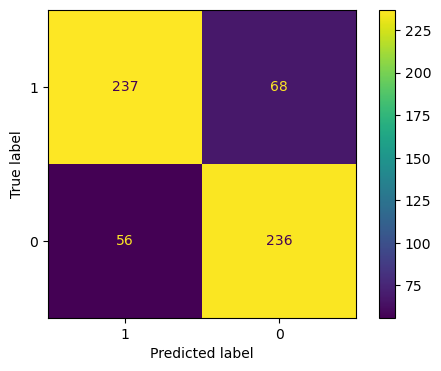

              precision    recall  f1-score   support

           0       0.81      0.78      0.79       305
           1       0.78      0.81      0.79       292

    accuracy                           0.79       597
   macro avg       0.79      0.79      0.79       597
weighted avg       0.79      0.79      0.79       597



In [212]:
#predict y values from X_test set
y_pred = model_6.predict(X_test)

#determine accuracy of model using actual y_test values and predicted y_pred values
print('Model 6 ROC AUC score: {0:0.4f}'. format(roc_auc_score(y_test, y_pred)))

#display confustion matrix for base model of XGBoost
display_confusion_matrix(y_test, y_pred, model_6)

#classification report
class_report(y_test, y_pred)


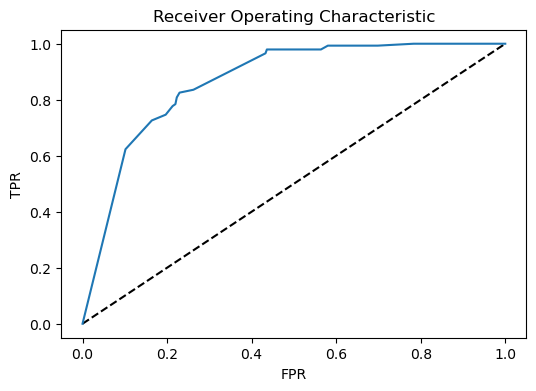

In [213]:
#ROC curve for XGBoost with grid search for OVERsampling data
y_pred_prob1 = model_6.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Model 6")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

# 5. Feature Importance Using SHAP

In [206]:
#extracting important features using shap package
explainer=shap.Explainer(model_xgb_2)
shap_values=explainer(X_train)
np.shape(shap_values.values)

(1393, 20)

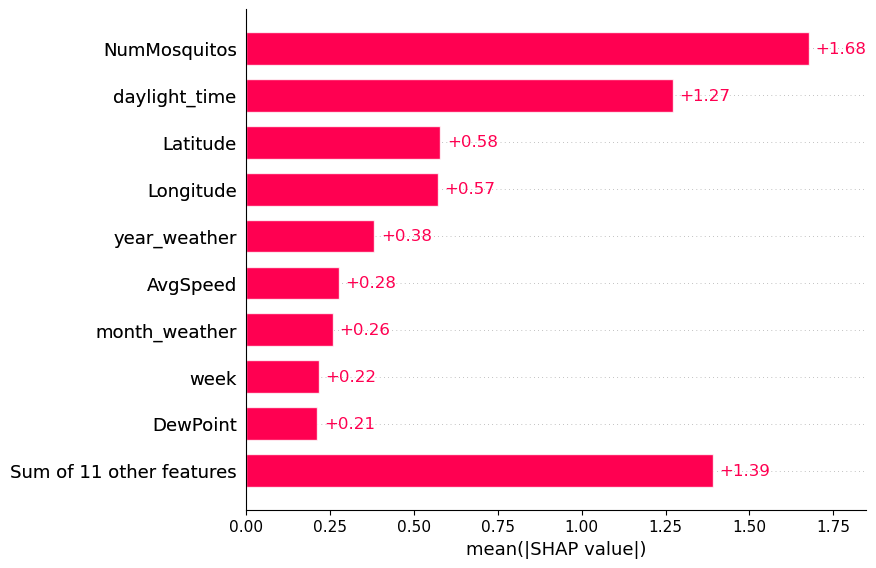

In [207]:
#feature importance
shap.plots.bar(shap_values, show=False)
plt.savefig('shap_values.png')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


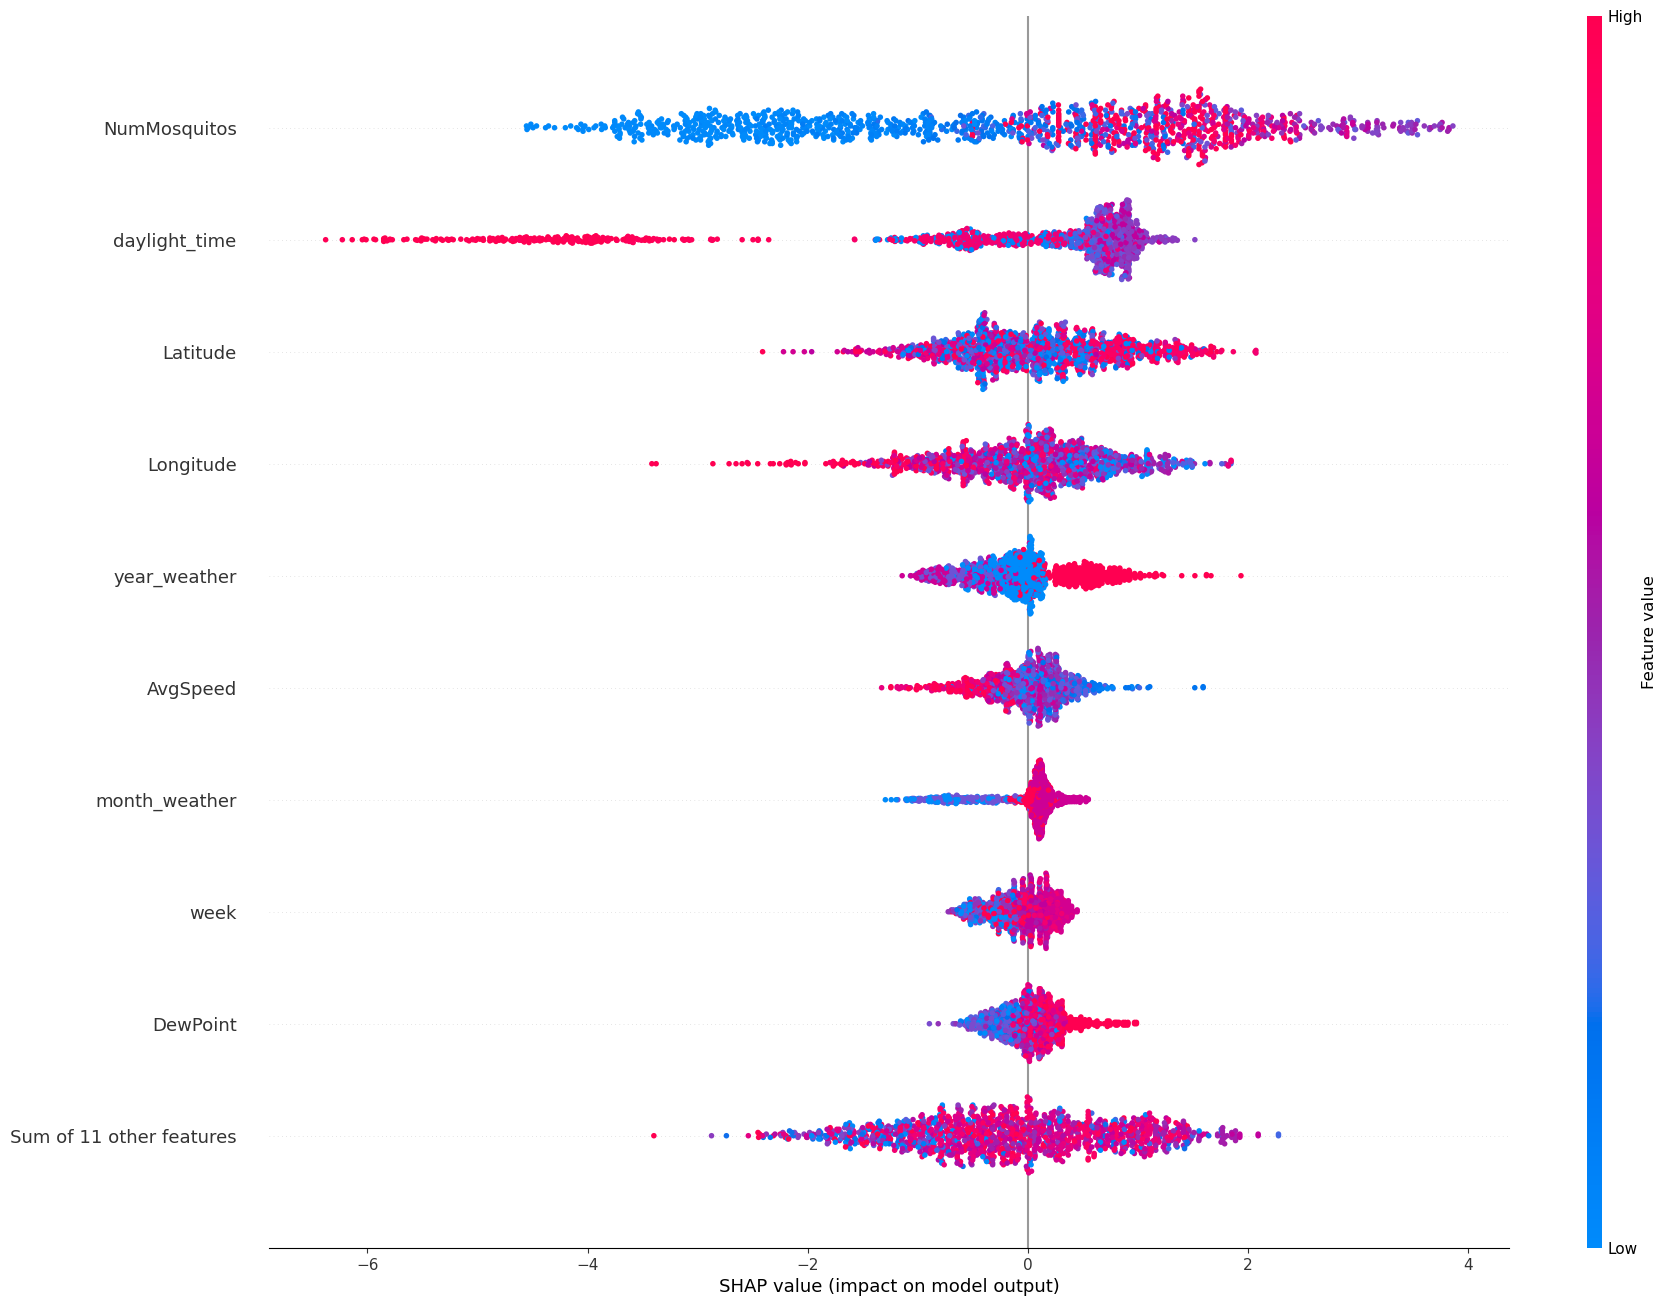

In [208]:
#Beeswarm plot to plot each SHAP value for each feature and their respective feature value. 
shap.plots.beeswarm(shap_values, plot_size=[20,16], show=False)
plt.savefig('bee.png')